In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [3]:
bs_168 = Bitome('NC_000964.3_2.gb', gene_table = 'gene_info_supp_1.csv', tu_table = 'tu_bs.csv', tss_table = 'tss_bs.csv', riboswitch_table = 'riboswitch_bs.csv')


## Expression Distribution

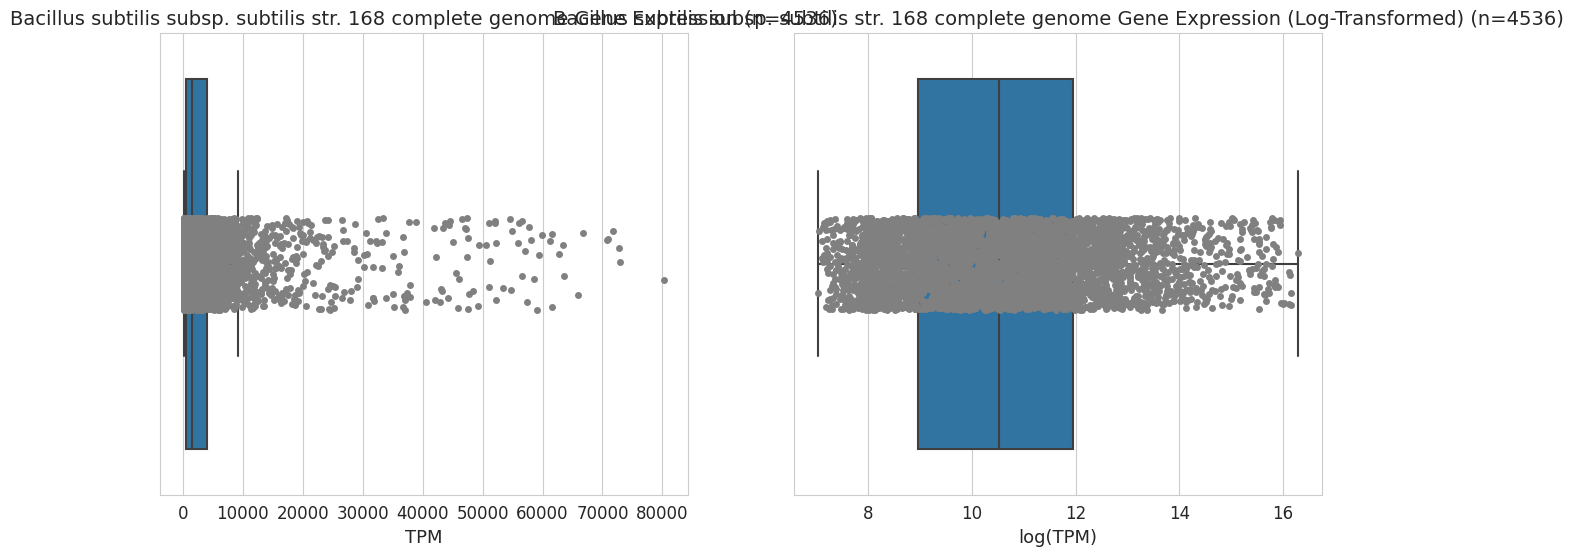

In [4]:
bs_168.expression_distribution();

## TU Expression Overview

reindexing with a non-unique Index is deprecated and will raise in a future version.


ValueError: cannot reindex on an axis with duplicate labels

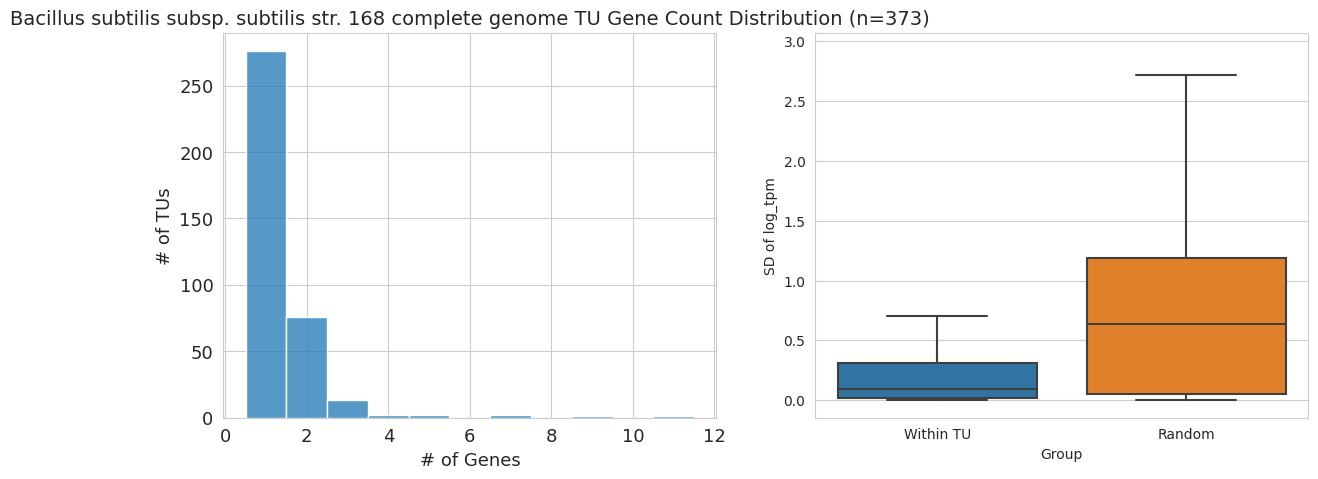

In [5]:
bs_168.within_tu_expression();

## Modeling - One-Hot Features Only

In [8]:
Xy_to_try = {}
one_hot_tus = bs_168.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)
one_hot_tus.head()

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
new_24_297_c,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
new_299_1067_c,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
BSU_00010,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
BSU_00030,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
BSU_00050,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [9]:
one_hot_tus_local = bs_168.one_hot_encode_tu_promoters(local_align=True, tss_radius=4, box_10_radius=10,
                                                      box_35_radius=10)
one_hot_tus_local.head()

,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,...,-35_8_G,-35_8_T,-35_9_A,-35_9_C,-35_9_G,-35_9_T,-35_10_A,-35_10_C,-35_10_G,-35_10_T
new_24_297_c,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
new_299_1067_c,0,1,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
BSU_00010,0,0,0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
BSU_00030,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
BSU_00050,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


## Gene Expression Based

In [10]:
gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in bs_168.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = bs_168._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)
            
    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

In [11]:
Xy_to_try = {
    '1tss__wt': Xy_to_try['1tss__wt'],
    'prom_avg__wt': Xy_to_try['prom_avg__wt']
}

In [12]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try)

In [13]:
Xy_train

{'1tss__wt': (           -50_A  -50_C  -50_G  -50_T  -49_A  -49_C  -49_G  -49_T  -48_A  \
  BSU_07020      0      0      1      0      0      0      0      1      0   
  BSU_25820      1      0      0      0      0      0      1      0      0   
  BSU_19680      0      0      1      0      0      1      0      0      0   
  BSU_32470      1      0      0      0      0      0      1      0      1   
  BSU_36210      0      1      0      0      0      0      0      1      1   
  ...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
  BSU_19790      1      0      0      0      0      0      0      1      0   
  BSU_11079      0      1      0      0      0      0      1      0      0   
  BSU_07170      0      0      0      1      0      0      0      1      0   
  BSU_11920      0      0      0      1      1      0      0      0      0   
  BSU_08040      0      0      0      1      0      0      1      0      0   
  
             -48_C  ...  8_G  8_T  9_A  9_C  9_G 

## Profile Models

In [14]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

SVR: 1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: 1tss__wt__X_raw__y_log
SVR: 1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: 1tss__wt__X_standard__y_log
SVR: prom_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: prom_avg__wt__X_raw__y_log
SVR: prom_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: prom_avg__wt__X_standard__y_log
RF: 1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: 1tss__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: 1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: 1tss__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: prom_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: prom_avg__wt__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: prom_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: prom_avg__wt__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


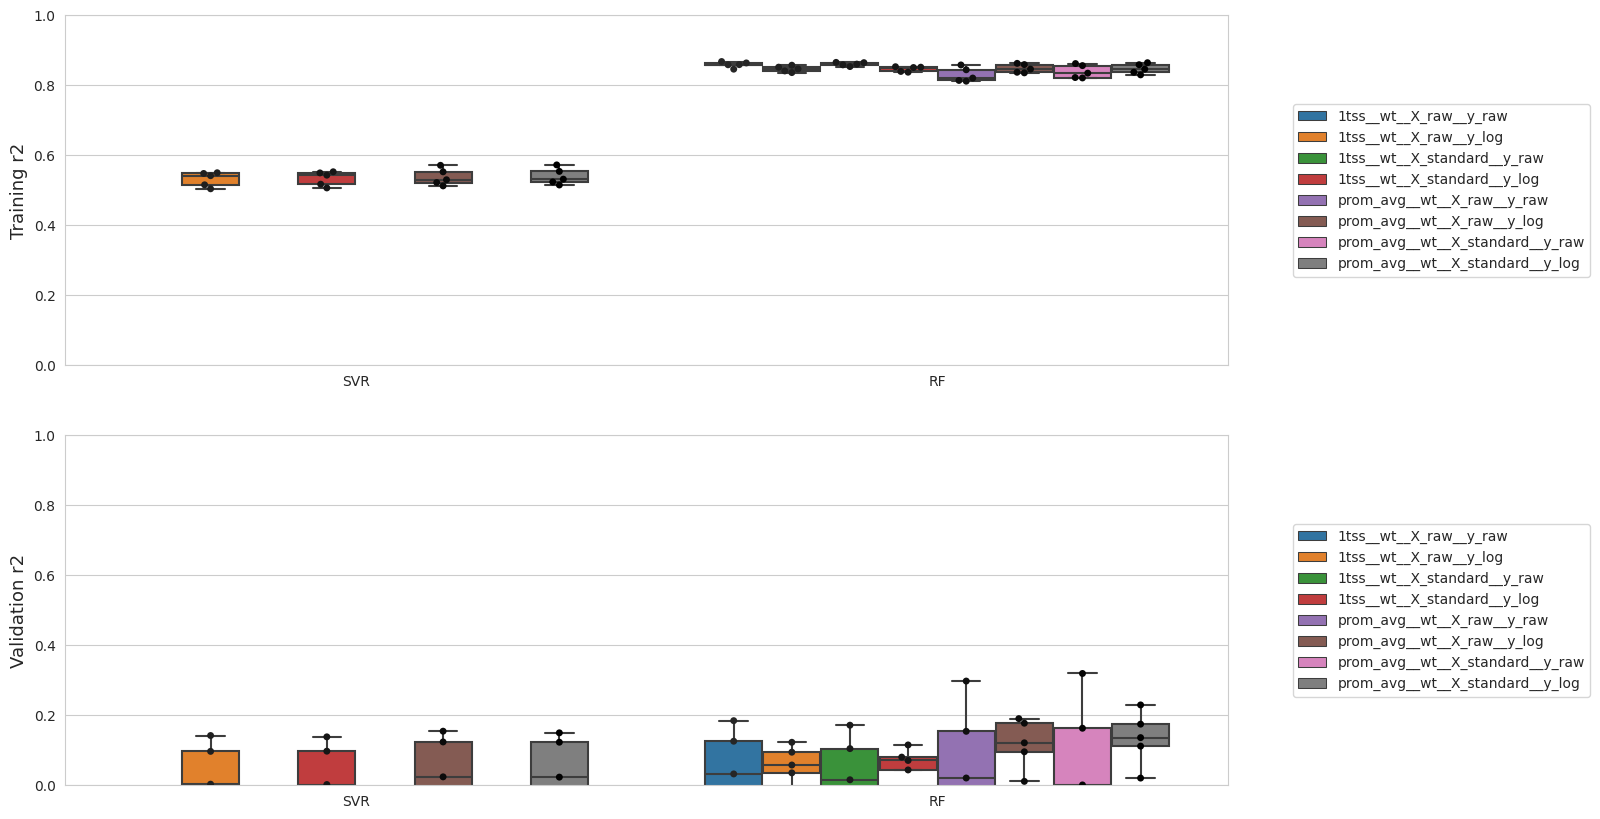

In [15]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'], y_preprocessing=['log'],
                                                           verbose=True)

In [16]:
model_profile_df

,model,xy,train_score,val_score
0,SVR,1tss__wt__X_raw__y_raw,-0.119351,-0.056085
1,SVR,1tss__wt__X_raw__y_raw,-0.110629,-0.158454
2,SVR,1tss__wt__X_raw__y_raw,-0.117748,-0.117351
3,SVR,1tss__wt__X_raw__y_raw,-0.107990,-0.199869
4,SVR,1tss__wt__X_raw__y_raw,-0.120192,-0.169780
...,...,...,...,...
0,RF,prom_avg__wt__X_standard__y_log,0.837255,0.111889
1,RF,prom_avg__wt__X_standard__y_log,0.829780,0.229572
2,RF,prom_avg__wt__X_standard__y_log,0.864480,0.020578
3,RF,prom_avg__wt__X_standard__y_log,0.846123,0.174682


Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


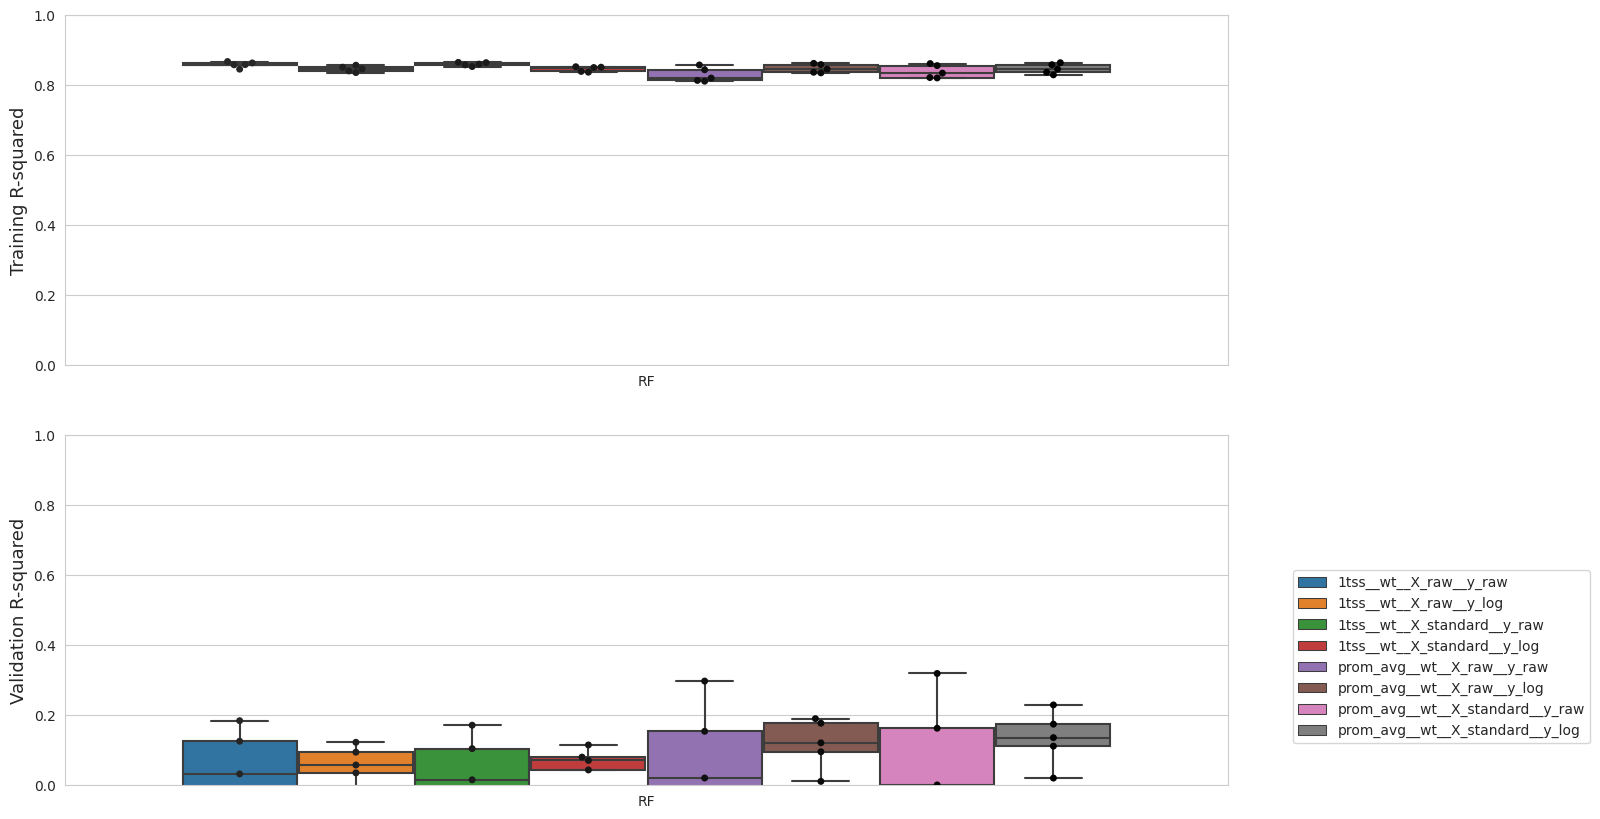

In [17]:
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')

## Feature Importances

In [18]:
x_oh_fi_raw = Xy_train['1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

## Random Forest Along Promoter

<AxesSubplot: xlabel='bp from TSS', ylabel='Feature Importance'>

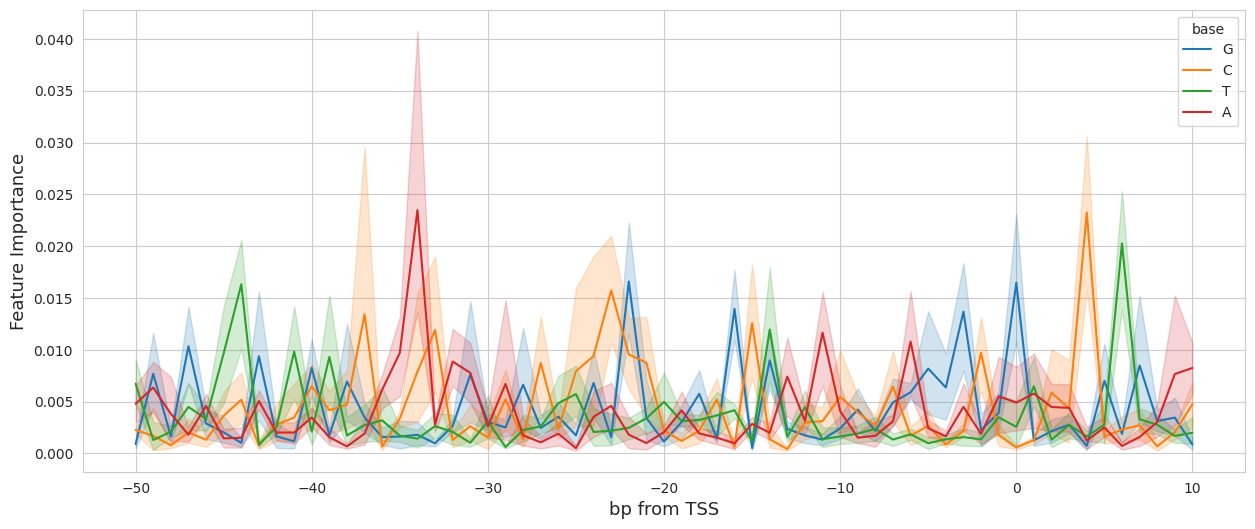

In [19]:
one_hot_feature_importance(x_oh_fi_std, y_oh_fi_raw, models_to_try['RF'], scoring='r2', n_cv=5)

## Shapley Values

In [20]:
x_oh_fi_std

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
BSU_07020,-0.683872,-0.487011,1.726088,-0.559397,-0.639343,-0.466546,-0.539416,1.507046,-0.667602,-0.441641,...,-0.478852,-0.667602,-0.599295,-0.503236,1.826767,-0.659503,-0.575356,-0.474760,1.604392,-0.635324
BSU_25820,1.462262,-0.487011,-0.579345,-0.559397,-0.639343,-0.466546,1.853856,-0.663550,-0.667602,-0.441641,...,-0.478852,1.497898,-0.599295,-0.503236,1.826767,-0.659503,-0.575356,-0.474760,1.604392,-0.635324
BSU_19680,-0.683872,-0.487011,1.726088,-0.559397,-0.639343,2.143409,-0.539416,-0.663550,-0.667602,-0.441641,...,-0.478852,-0.667602,1.668626,-0.503236,-0.547415,-0.659503,1.738054,-0.474760,-0.623289,-0.635324
BSU_32470,1.462262,-0.487011,-0.579345,-0.559397,-0.639343,-0.466546,1.853856,-0.663550,1.497898,-0.441641,...,-0.478852,-0.667602,-0.599295,1.987138,-0.547415,-0.659503,-0.575356,-0.474760,1.604392,-0.635324
BSU_36210,-0.683872,2.053343,-0.579345,-0.559397,-0.639343,-0.466546,-0.539416,1.507046,1.497898,-0.441641,...,2.088327,-0.667602,-0.599295,1.987138,-0.547415,-0.659503,-0.575356,-0.474760,1.604392,-0.635324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_19790,1.462262,-0.487011,-0.579345,-0.559397,-0.639343,-0.466546,-0.539416,1.507046,-0.667602,-0.441641,...,-0.478852,-0.667602,-0.599295,-0.503236,-0.547415,1.516293,-0.575356,-0.474760,1.604392,-0.635324
BSU_11079,-0.683872,2.053343,-0.579345,-0.559397,-0.639343,-0.466546,1.853856,-0.663550,-0.667602,-0.441641,...,-0.478852,-0.667602,-0.599295,-0.503236,1.826767,-0.659503,-0.575356,-0.474760,1.604392,-0.635324
BSU_07170,-0.683872,-0.487011,-0.579345,1.787639,-0.639343,-0.466546,-0.539416,1.507046,-0.667602,2.264284,...,-0.478852,1.497898,-0.599295,1.987138,-0.547415,-0.659503,-0.575356,2.106328,-0.623289,-0.635324
BSU_11920,-0.683872,-0.487011,-0.579345,1.787639,1.564106,-0.466546,-0.539416,-0.663550,-0.667602,-0.441641,...,-0.478852,-0.667602,-0.599295,-0.503236,-0.547415,1.516293,-0.575356,2.106328,-0.623289,-0.635324


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

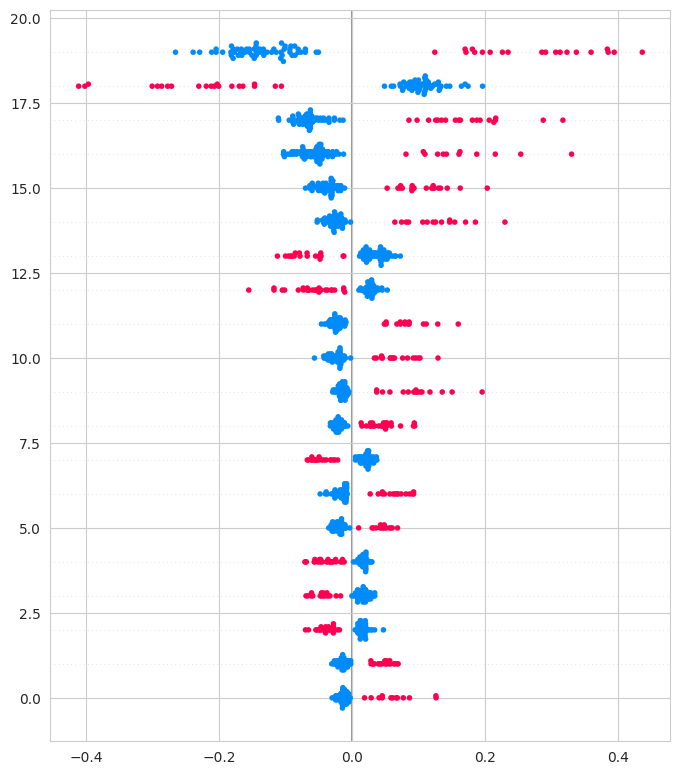

In [21]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

### Predicted vs Actual

Text(0.5, 0.05, 'R-square: 0.17\nPearson R: 0.42 (P=1.31E-04)\nSpearman R: 0.25 (P=3.03E-02)')

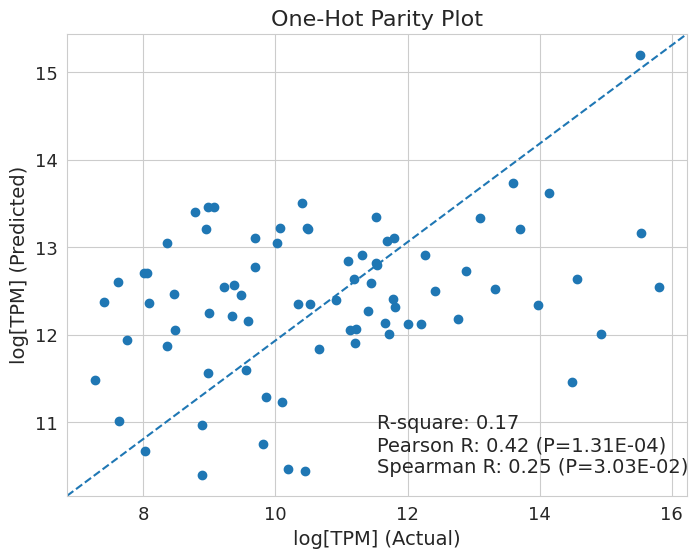

In [22]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2)
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_log, y_pred_log)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

## Genome Organization Features

In [23]:
gene_table_copy = bs_168.gene_table.copy()
go_table = bs_168.genome_organization_table(n_genome_bins=32, tm_range=(-13, -7), tm_use_box=False).dropna()
gene_table_ml = go_table.merge(gene_table_copy, left_index=True, right_index=True, how='left')
gene_table_ml = gene_table_ml.dropna(subset=['tpm'])
# we only want things with -10 and -35 box that have length 6 (for now) so we can one-hot
# we want to allow the 'reg_effect' column to be empty, have that as category
gene_table_ml['reg_effect'] = gene_table_ml['reg_effect'].fillna('none')
gene_table_ml

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

,genome_loc_sin,genome_loc_cos,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,utr_gc,box_10_seq,...,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
BSU_00370,-0.195090,0.980785,1308.0,0.347095,1.0,470.0,C,470.0,0.278723,ACCTCCTAATCAGAATGTC,...,False,abrB,Transcription,essential,well-annotated,9928.507666,17146.185070,11540.355130,"Spo0A,SigA,AbrB",13.277506
BSU_02130,-0.382683,0.923880,1689.0,0.458259,1.0,525.0,A,525.0,0.487619,TTTACGAATACGCAGGCAT,...,False,glpQA,Energy production and conversion,essential,well-annotated,708.164694,273.292110,499.468540,"SigA,GlpP,PhoP,CcpA",9.469977
BSU_03690,-0.707107,0.707107,363.0,0.371901,1.0,167.0,T,167.0,0.359281,CGTCTGTATTCTGCTTGTC,...,False,yczF,No COG category,essential,well-annotated,264.039908,205.144974,208.362234,SigG,8.050066
BSU_04820,-0.831470,0.555570,1329.0,0.308503,1.0,702.0,G,702.0,0.300570,ACTACGGATGATTGCCGAA,...,False,immR,No COG category,essential,well-annotated,3851.441232,9744.010686,4321.750288,unknown,11.911557
BSU_05230,-0.831470,0.555570,1733.0,0.454703,1.0,416.0,C,416.0,0.387019,TGTTGTGCTTGGCATTCTA,...,False,ydeK,Amino acid transport and metabolism,essential,well-annotated,222.265351,192.551426,206.521762,unknown,7.802616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40870,0.000000,1.000000,1332.0,0.426426,1.0,433.0,T,433.0,0.404157,AATGGGAAGAGGCTTTACT,...,False,ccpB,No COG category,essential,well-annotated,432.019070,586.383216,439.326587,SigG,8.758287
BSU_40890,0.000000,1.000000,1467.0,0.439673,2.0,895.0,A,333.0,0.402402,AGTCCAAAAGGAGGTGCAA,...,False,rpsR,"Translation, ribosomal structure and biogenesis",essential,well-annotated,61541.353710,92675.476030,79625.891520,"ComK,SigA,stringent response",15.909292
BSU_40900,0.000000,1.000000,1467.0,0.439673,1.0,333.0,A,333.0,0.402402,AGTCCAAAAGGAGGTGCAA,...,False,ssbA,"Replication, recombination and repair",essential,well-annotated,56542.322760,92810.473520,73067.893730,"ComK,SigA,stringent response",15.787069


In [24]:
go_table

,genome_loc_sin,genome_loc_cos,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,utr_gc,box_10_seq,box_10_tss_dist,box_10_ext_gc,box_35_seq,box_35_tss_dist,tu_tm,tu_gatc,spacer_len,spacer_gc
locus_tag,,,,,,,,,,,,,,,,,,
BSU_00370,-0.195090,0.980785,1308.0,0.347095,1.0,470.0,C,470.0,0.278723,ACCTCCTAATCAGAATGTC,0.0,0.333333,TATTGTTTTCTTGCGGCAT,25.0,-13.914870,False,6.0,0.333333
BSU_02130,-0.382683,0.923880,1689.0,0.458259,1.0,525.0,A,525.0,0.487619,TTTACGAATACGCAGGCAT,1.0,0.333333,GAAGACTCACGCTGGTCGT,26.0,-1.648841,False,6.0,0.166667
BSU_03690,-0.707107,0.707107,363.0,0.371901,1.0,167.0,T,167.0,0.359281,CGTCTGTATTCTGCTTGTC,1.0,0.000000,TCTTGCTGCTGTTCCTGAT,26.0,-13.914870,False,6.0,0.333333
BSU_04820,-0.831470,0.555570,1329.0,0.308503,1.0,702.0,G,702.0,0.300570,ACTACGGATGATTGCCGAA,1.0,0.666667,CCCTATAGTGGTATATAAC,25.0,-12.036781,False,5.0,0.600000
BSU_05230,-0.831470,0.555570,1733.0,0.454703,1.0,416.0,C,416.0,0.387019,TGTTGTGCTTGGCATTCTA,2.0,1.000000,TCTTCTGCTTCTTGTTGAA,25.0,2.695326,False,4.0,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BSU_40870,0.000000,1.000000,1332.0,0.426426,1.0,433.0,T,433.0,0.404157,AATGGGAAGAGGCTTTACT,2.0,0.666667,TTAGAGCGGATTGATTACC,27.0,-0.100947,False,6.0,0.666667
BSU_40890,0.000000,1.000000,1467.0,0.439673,2.0,895.0,A,333.0,0.402402,AGTCCAAAAGGAGGTGCAA,0.0,0.333333,GCTCCTTGCCCATTATGGG,25.0,-10.782002,False,6.0,0.666667
BSU_40900,0.000000,1.000000,1467.0,0.439673,1.0,333.0,A,333.0,0.402402,AGTCCAAAAGGAGGTGCAA,0.0,0.333333,GCTCCTTGCCCATTATGGG,25.0,-10.782002,False,6.0,0.666667


## Genome Location

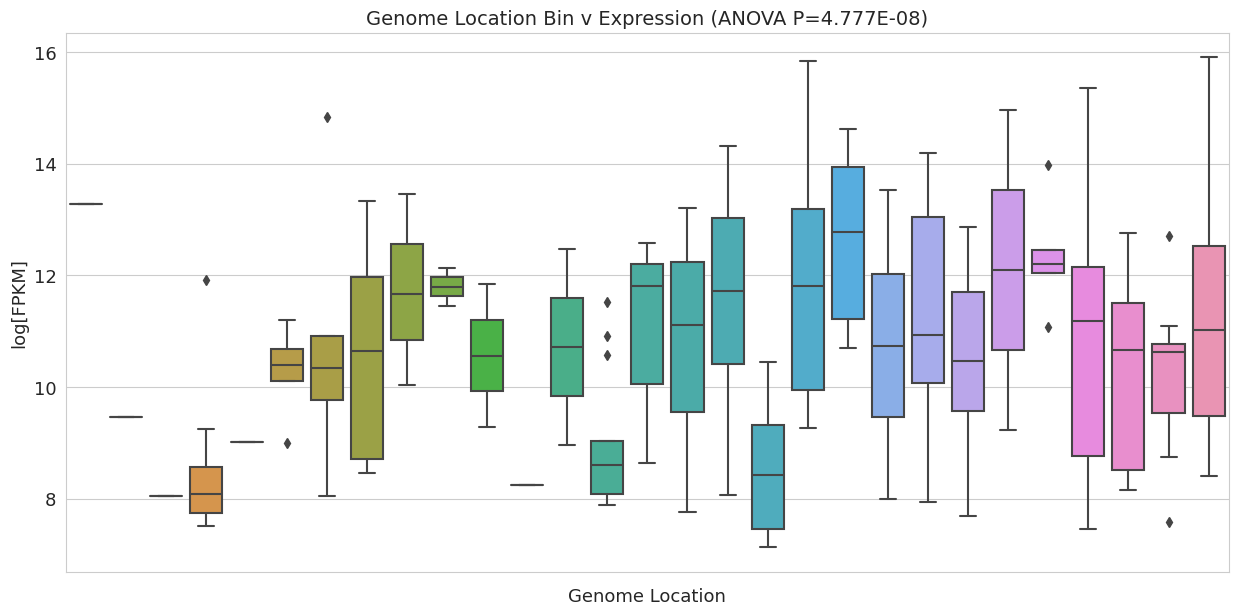

In [25]:
genome_loc_df = gene_table_ml[['genome_loc_cos', 'genome_loc_sin', 'log_tpm']].copy()
genome_loc_df['sincos'] = genome_loc_df.apply(
    lambda row: str(row.genome_loc_cos) + str(row.genome_loc_sin), axis=1
)

exp_groups = []
for sincos, gloc_df in genome_loc_df.groupby('sincos'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='sincos', y='log_tpm', data=genome_loc_df, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels([])
ax.set_xlabel("Genome Location", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f'Genome Location Bin v Expression (ANOVA P={p:.3E})', fontsize=14);

## Order in TU

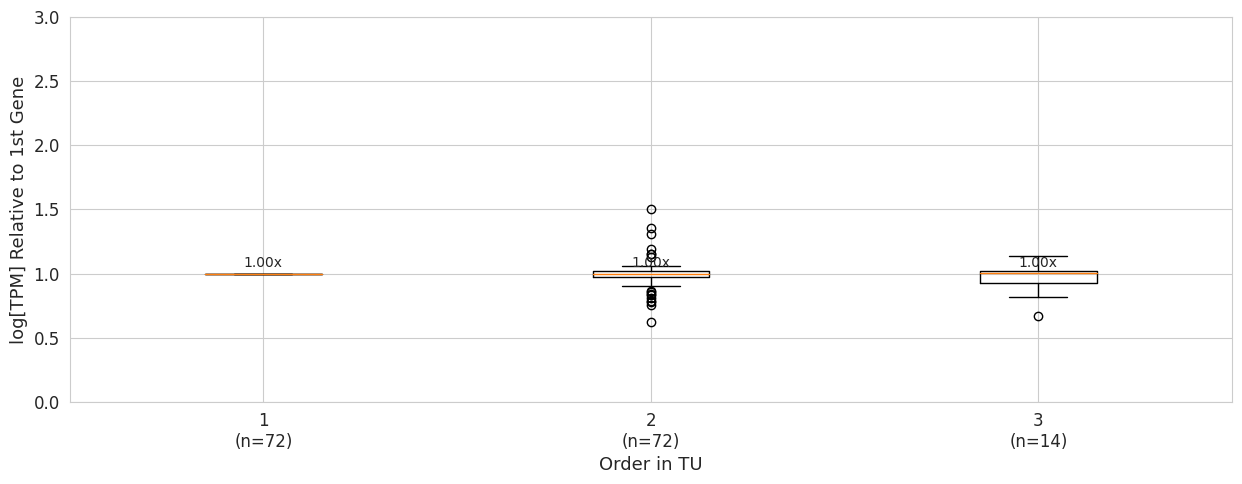

In [26]:
tu_rel_exps = {}

for tu_row in bs_168.tu_table.itertuples():

    tu_genes = bs_168._tu_to_genes[tu_row.Index]
    tu_gene_df = bs_168.gene_table[bs_168.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])

    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        for i, rel_exp in enumerate(tu_gene_exps_rel):
            if i in tu_rel_exps:
                tu_rel_exps[i].append(rel_exp)
            else:
                tu_rel_exps[i] = [rel_exp]
                
tu_rel_exps = {k: v for k, v in tu_rel_exps.items() if len(v) > 10}

_, ax = plt.subplots(figsize=(15, 5))

ax.boxplot(list(tu_rel_exps.values()))
ax.set_xticklabels([f'{i+1}\n(n={len(vals)})' for i, vals in enumerate(tu_rel_exps.values())])
ax.set_xlabel('Order in TU', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(bottom=0, top=3)
for i, vals in enumerate(tu_rel_exps.values()):
    med = np.median(vals)
    ax.text(i+1, med+0.05, f'{med:.2f}x', ha='center')

## Distance to TSS

(0.0, 3.0)

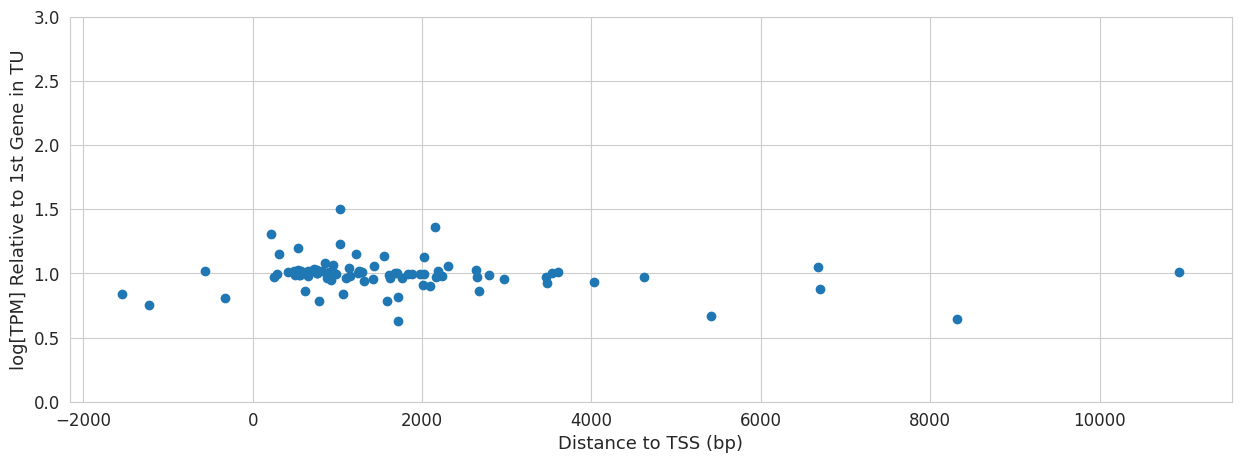

In [27]:
all_tss_dists = []
all_rel_exps_tss = []

for tu_row in bs_168.tu_table.itertuples():
    tu_genes = bs_168._tu_to_genes[tu_row.Index]
    tu_gene_df = bs_168.gene_table[bs_168.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
            tss_dists = sorted_gene_df['left'].values - tu_row.tss
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
            tss_dists = tu_row.tss - sorted_gene_df['right']
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        # ignore the first gene in the TU, this will just give us a bunch of y-values of 1 
        all_tss_dists += list(tss_dists[1:])
        all_rel_exps_tss += list(tu_gene_exps_rel[1:])
        
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(all_tss_dists, all_rel_exps_tss)
ax.set_xlabel('Distance to TSS (bp)', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene in TU', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0, 3)

## TU Length

Text(0, 0.5, 'log[TPM]')

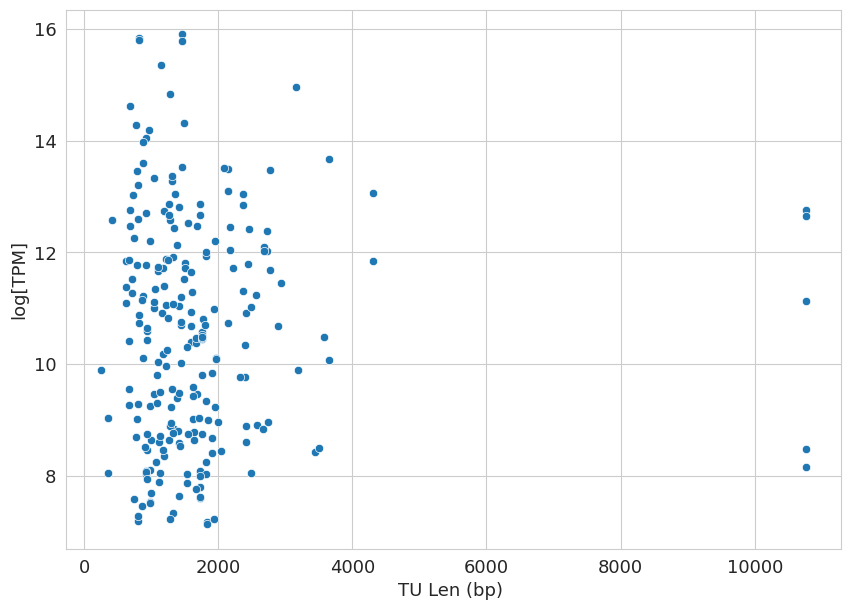

In [28]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## TU GC Content

Text(0, 0.5, 'log[FPKM]')

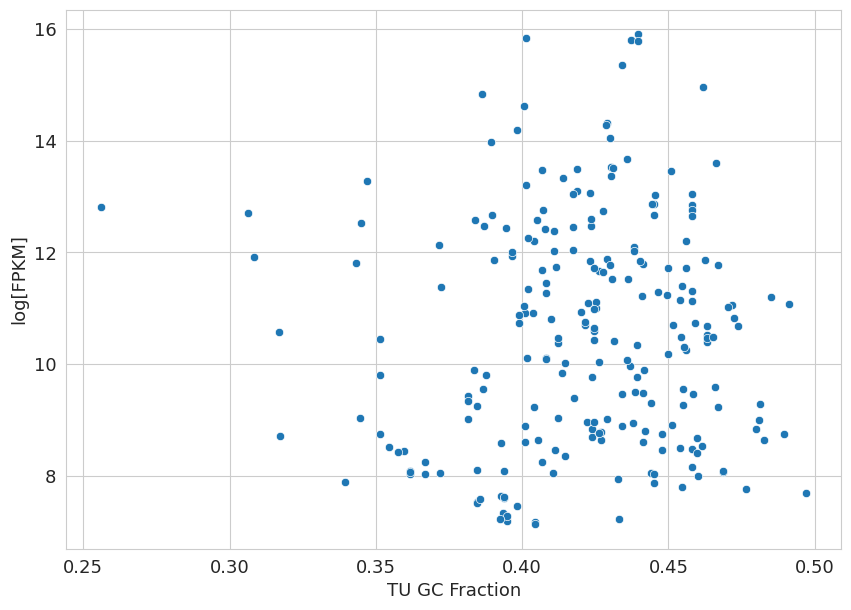

In [29]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC Fraction", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## TSS Base

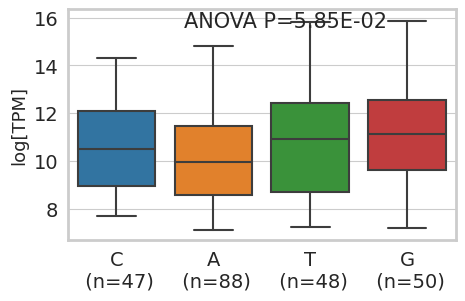

In [30]:
sns.set_style('whitegrid')

exp_groups = []
for tss_base, gloc_df in gene_table_ml.groupby('tss_base'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(x='tss_base', y='log_tpm', data=gene_table_ml, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
#ax.set_title(f"TSS Base (ANOVA P={p:.2E})", fontsize=14)
ax.text(0.3, 0.92, f"ANOVA P={p:.2E}", fontsize=15, transform=ax.transAxes)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={gene_table_ml[gene_table_ml['tss_base'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/tss_base.svg')

## 5' UTR 

(0.0, 400.0)

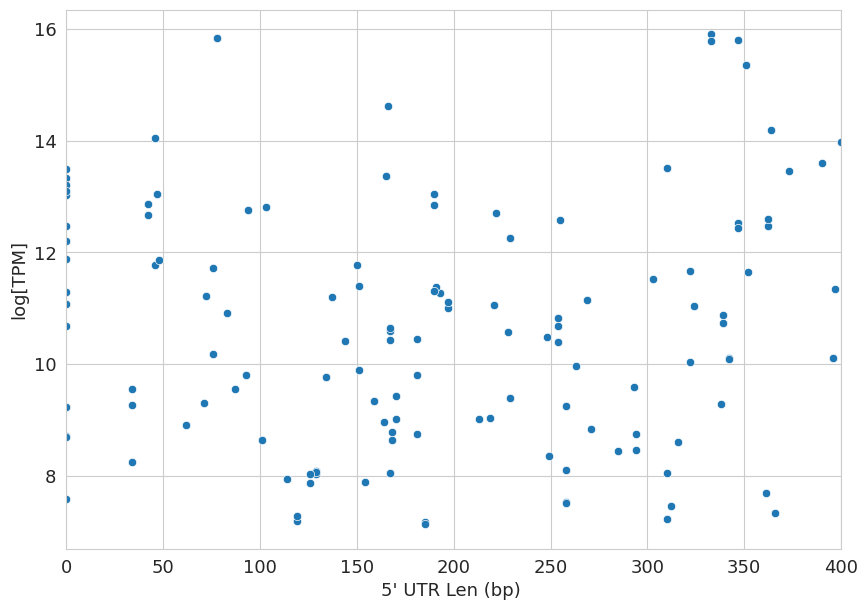

In [31]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xlim(0, 400)

Text(0, 0.5, 'log[TPM]')

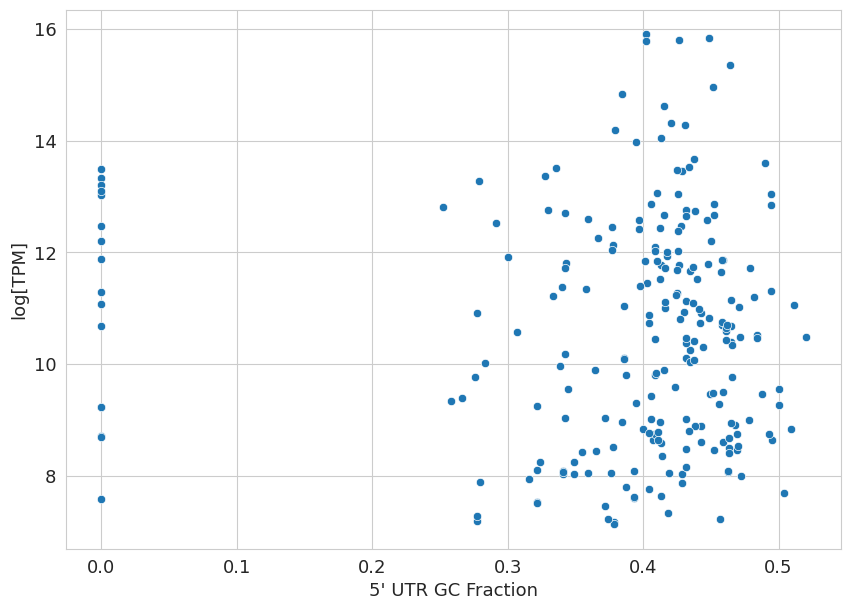

In [32]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC Fraction", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## -10 Box
#### Did not include cutoff

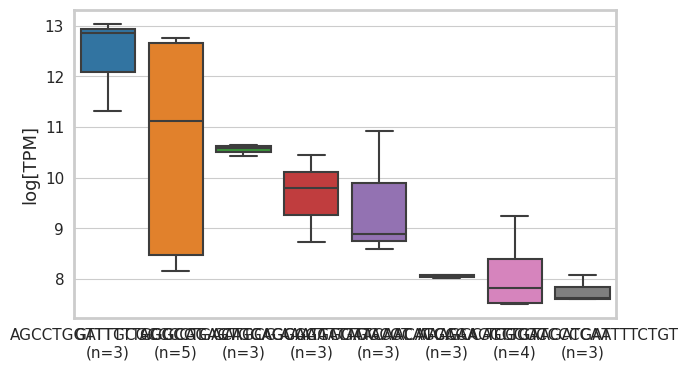

In [33]:
box_df = gene_table_ml[['box_10_seq', 'log_tpm']].dropna()
#print(box_df)
box_10_dfs = []

cutoff = 2
for _, b10seq_df in box_df.groupby('box_10_seq'):
    if b10seq_df.shape[0] > cutoff:
        box_10_dfs.append(b10seq_df)
    
        
box_10_dfs = sorted(box_10_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_10_df = pd.concat(box_10_dfs)

_, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x='box_10_seq', y='log_tpm', data=box_10_df, fliersize=0, ax=ax)
#sns.swarmplot(x='box_10_seq', y='log_tpm', data=box_10_df, ax=ax)
ax.tick_params(axis='both', labelsize=11)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_10_df[box_10_df['box_10_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()]);
# ax.set_title(f"-10 Box Sequence (n={len(box_df['box_10_seq'].unique())}; {len(box_10_dfs)} with >{cutoff} genes shown)",
#              fontsize=14)
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/box_10.svg')

In [34]:
print(box_10_df)

                    box_10_seq    log_tpm
locus_tag                                
BSU_23650  AGCCTGGATTTTTAGGCGT  12.851081
BSU_23660  AGCCTGGATTTTTAGGCGT  13.037468
BSU_23670  AGCCTGGATTTTTAGGCGT  11.313081
BSU_37290  GTTTGCGCCCCTGACAGCG   8.156926
BSU_37310  GTTTGCGCCCCTGACAGCG  11.125905
BSU_37320  GTTTGCGCCCCTGACAGCG   8.477560
BSU_37330  GTTTGCGCCCCTGACAGCG  12.768014
BSU_37340  GTTTGCGCCCCTGACAGCG  12.657282
BSU_38670  GGGCAGAGTGGAGCGAAAC  10.591909
BSU_38680  GGGCAGAGTGGAGCGAAAC  10.650677
BSU_38690  GGGCAGAGTGGAGCGAAAC  10.430898
BSU_26558  GATTCAGGAGGGGATAAAT   9.795259
BSU_26559  GATTCAGGAGGGGATAAAT   8.737576
BSU_26560  GATTCAGGAGGGGATAAAT  10.442460
BSU_19660  AAATTTTTGGCGCAGCAGA   8.893957
BSU_19670  AAATTTTTGGCGCAGCAGA   8.598863
BSU_19680  AAATTTTTGGCGCAGCAGA  10.919032
BSU_20090  ATACAACATGGAAGGGCGC   8.087511
BSU_20100  ATACAACATGGAAGGGCGC   8.020739
BSU_20110  ATACAACATGGAAGGGCGC   8.060348
BSU_06034  AAAGCCATTTGTTCCCCAA   9.238595
BSU_06036  AAAGCCATTTGTTCCCCAA   8

## Distance to TSS

Text(0, 0.5, 'log[TPM]')

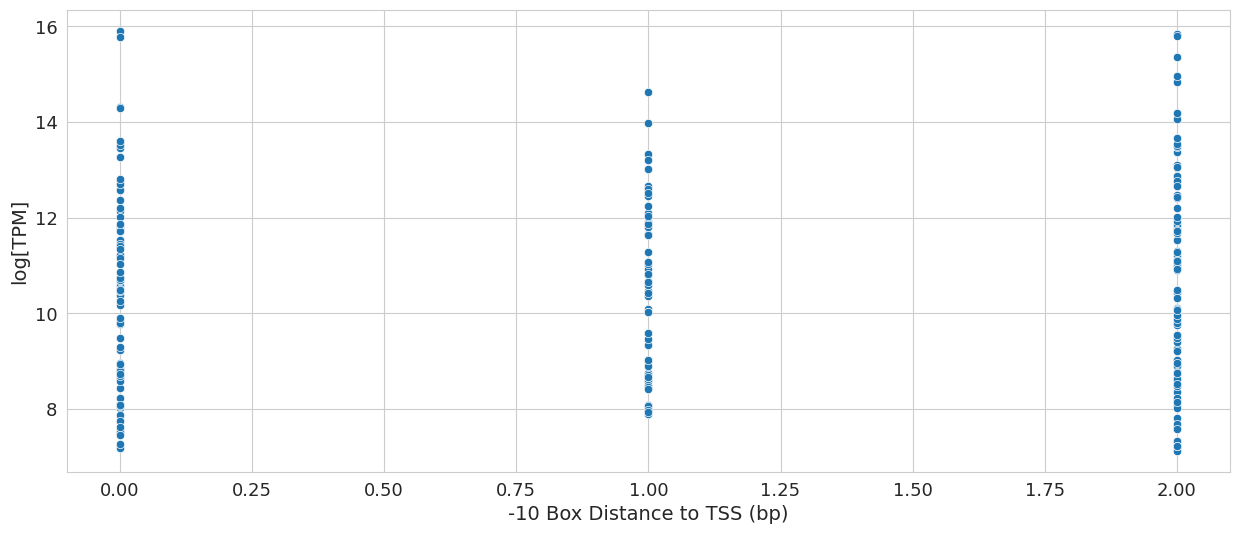

In [35]:
box_dist_df = gene_table_ml[['box_10_tss_dist', 'log_tpm']].dropna()
box_dist_df = box_dist_df[box_dist_df['box_10_tss_dist'] < 9]

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_10_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

### Extended Box GC Content

Text(0, 0.5, 'log[TPM]')

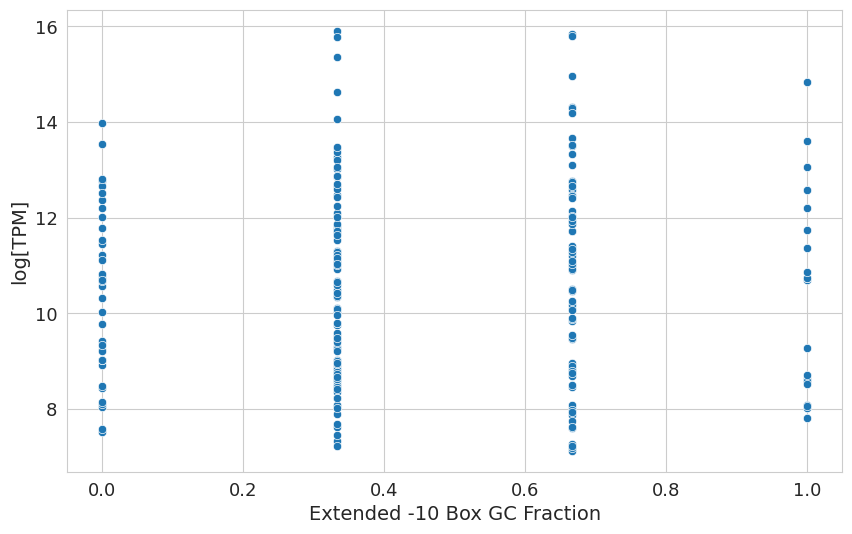

In [36]:
_, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='box_10_ext_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Extended -10 Box GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## -35 Box

Text(0.5, 1.0, '-35 Box Sequence (n=181; 8 genes shown)')

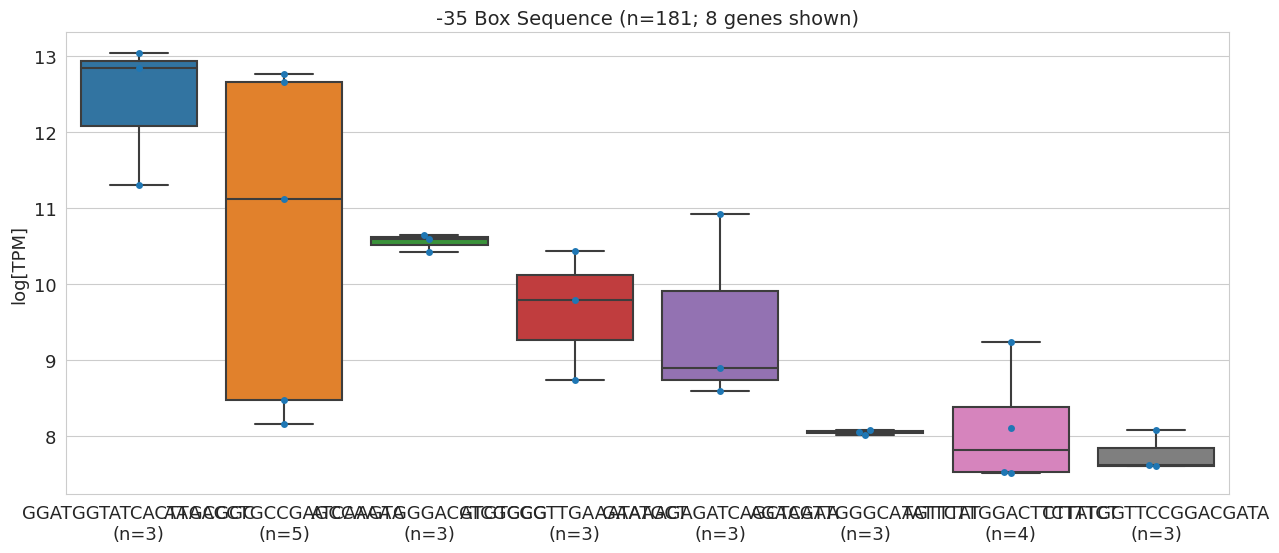

In [37]:
box_35_df_orig = gene_table_ml[['box_35_seq', 'log_tpm']].dropna()

box_35_dfs = []

cutoff = 2
for _, b35seq_df in box_35_df_orig.groupby('box_35_seq'):
    if b35seq_df.shape[0] > cutoff:
        box_35_dfs.append(b35seq_df)
        
box_35_dfs = sorted(box_35_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_35_df = pd.concat(box_35_dfs)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_35_seq', y='log_tpm', data=box_35_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_35_seq', y='log_tpm', data=box_35_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_35_df[box_35_df['box_35_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title(f"-35 Box Sequence (n={len(box_35_df_orig['box_35_seq'].unique())}; {len(box_35_dfs)} genes shown)",
             fontsize=14)

In [38]:
print(box_35_df)

                    box_35_seq    log_tpm
locus_tag                                
BSU_23650  GGATGGTATCACTTGCGGC  12.851081
BSU_23660  GGATGGTATCACTTGCGGC  13.037468
BSU_23670  GGATGGTATCACTTGCGGC  11.313081
BSU_37290  AAAACCTGCCGAGCCAAAA   8.156926
BSU_37310  AAAACCTGCCGAGCCAAAA  11.125905
BSU_37320  AAAACCTGCCGAGCCAAAA   8.477560
BSU_37330  AAAACCTGCCGAGCCAAAA  12.768014
BSU_37340  AAAACCTGCCGAGCCAAAA  12.657282
BSU_38670  ATCAAGTGGGACGTGTCGG  10.591909
BSU_38680  ATCAAGTGGGACGTGTCGG  10.650677
BSU_38690  ATCAAGTGGGACGTGTCGG  10.430898
BSU_26558  ATCGGCGTTGAAATATGCT   9.795259
BSU_26559  ATCGGCGTTGAAATATGCT   8.737576
BSU_26560  ATCGGCGTTGAAATATGCT  10.442460
BSU_19660  GAAAAGAGATCAGCTCAAA   8.893957
BSU_19670  GAAAAGAGATCAGCTCAAA   8.598863
BSU_19680  GAAAAGAGATCAGCTCAAA  10.919032
BSU_20090  AGAAGTTGGGCAAGTTTAT   8.087511
BSU_20100  AGAAGTTGGGCAAGTTTAT   8.020739
BSU_20110  AGAAGTTGGGCAAGTTTAT   8.060348
BSU_06034  TATTCTTGGACTTCTTTCT   9.238595
BSU_06036  TATTCTTGGACTTCTTTCT   8

### Distance to TSS

Text(0, 0.5, 'log[TPM]')

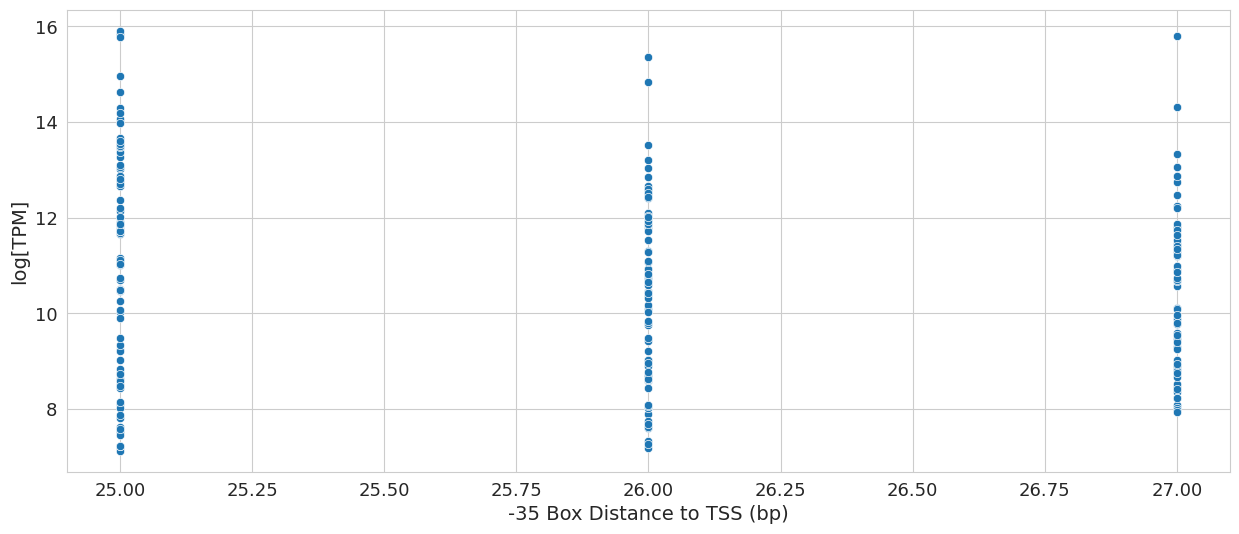

In [39]:
box_dist_df = gene_table_ml[['box_35_tss_dist', 'log_tpm']].dropna()

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_35_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-35 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Spacer

Text(0, 0.5, 'log[TPM]')

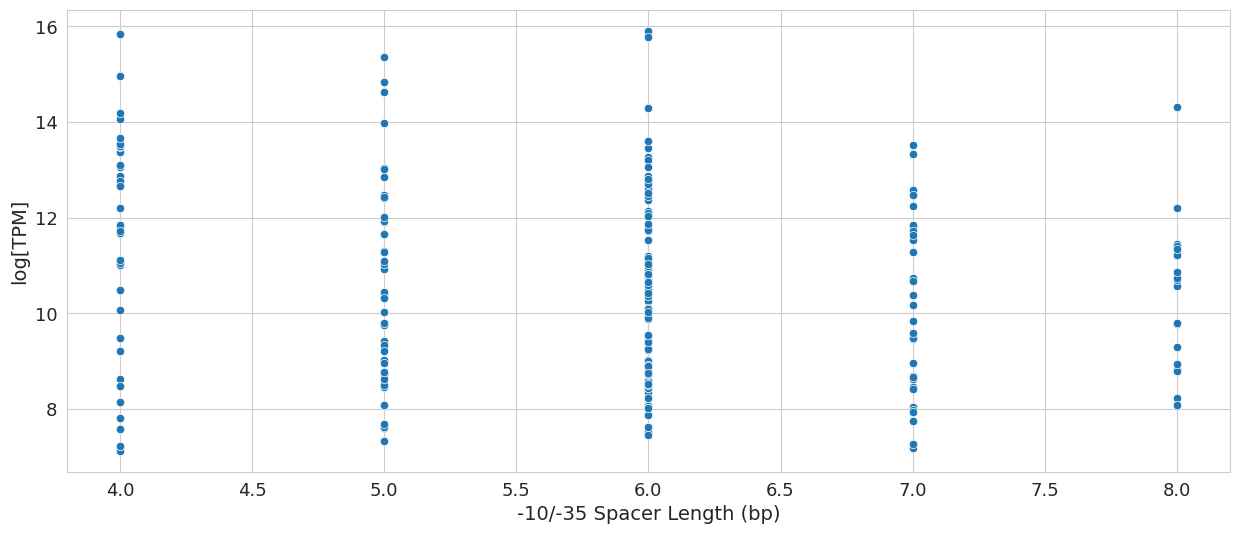

In [40]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer Length (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

Text(0, 0.5, 'log[TPM]')

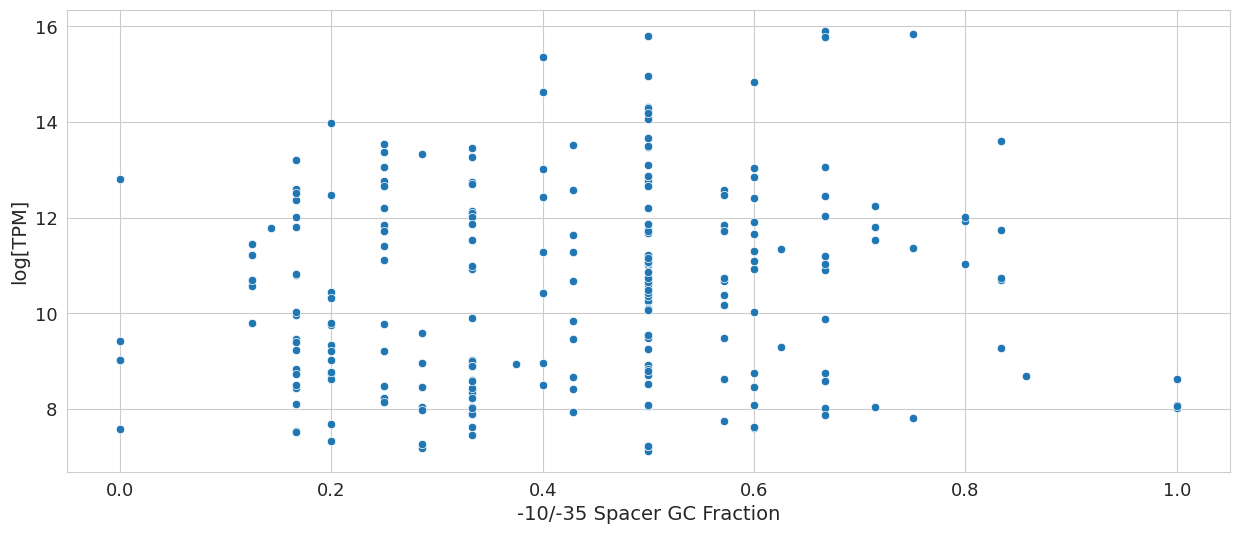

In [41]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Regulatory Effect

Text(0.5, 1.0, 'BS_168 Expression by Regulatory Effect (P = 1.498E-06)')

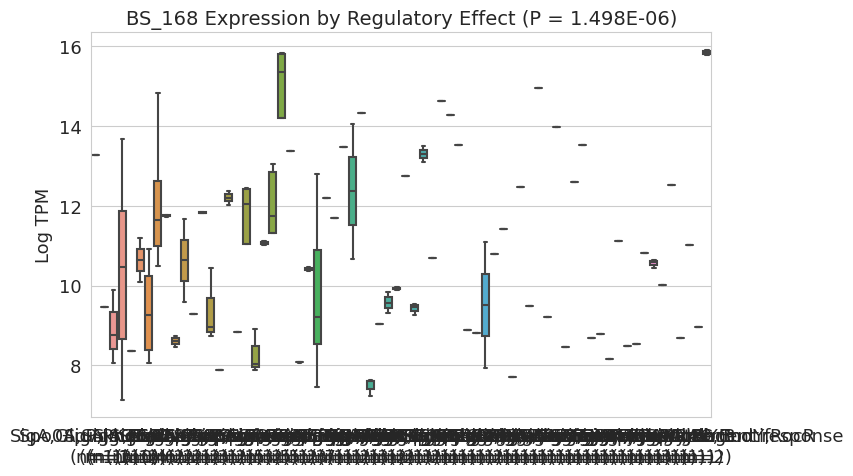

In [42]:
reg_effect_df = gene_table_ml.copy()
reg_effect_df['reg_effect'] = reg_effect_df['reg_effect'].fillna('none')

loc_groups = []
for loc, gloc_df in reg_effect_df.groupby('reg_effect'):
    loc_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*loc_groups)

_, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(x='reg_effect', y='log_tpm',
            data=reg_effect_df, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={reg_effect_df[reg_effect_df['reg_effect'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('Log TPM', fontsize=13)
ax.set_title(f'BS_168 Expression by Regulatory Effect (P = {p:.3E})', fontsize=14)